In [0]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch.optim as optim
%matplotlib inline
import seaborn as sn
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report 
from torch.utils.tensorboard import SummaryWriter
from itertools import product
from torch.utils.data.sampler import SubsetRandomSampler

In [2]:
torch.set_default_dtype(torch.float64)
torch.set_default_tensor_type('torch.cuda.FloatTensor')
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [0]:
class Network(nn.Module):
    def __init__(self):
        super(Network,self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1,out_channels=6,kernel_size=1)
        self.conv2 = nn.Conv2d(in_channels=6,out_channels=16,kernel_size=5)
        self.fc1 = nn.Linear(in_features=16*5*5,out_features=120)
        self.fc2 = nn.Linear(in_features=120,out_features=84)
        self.out = nn.Linear(in_features=84,out_features=10)
        self.leakyrelu = nn.LeakyReLU(negative_slope=0.2)

    def forward(self,t):
        t = self.leakyrelu(self.conv1(t))
        t = F.max_pool2d(t,kernel_size=2,stride=2)
        t = self.leakyrelu(self.conv2(t))
        t = F.max_pool2d(t,kernel_size=2,stride=2)
        t = t.reshape(-1,16*5*5)
        t = self.leakyrelu(self.fc1(t))
        t = self.leakyrelu(self.fc2(t))
        t = self.out(t)
        return t

In [0]:
def get_num_correct(pred,labels):
    return (pred.argmax(dim=1)==labels).sum().item()

In [0]:
def get_all_pred(network,loader):
  all_preds = torch.tensor([])
  for batch in loader:
    images,labels = batch
    pred = network(images)
    all_preds = torch.cat((all_preds,pred),dim=0)

  return all_preds

In [6]:
data = torchvision.datasets.MNIST(
    root = './data',
    train = True,
    download = True,
    transform = transforms.Compose([transforms.ToTensor()])
)

0it [00:00, ?it/s]

9920512it [00:01, 8820191.85it/s]                            


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


  0%|          | 0/28881 [00:00<?, ?it/s]

32768it [00:00, 123367.53it/s]                           
  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


1654784it [00:00, 2237495.78it/s]                            
0it [00:00, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


8192it [00:00, 51582.21it/s]            


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


In [0]:
sample = next(iter(data))

In [8]:
image, label = sample
image.shape

torch.Size([1, 28, 28])

In [0]:
parameters = dict(
    batch_size = [32,64,128],
    lr = [0.01,0.001],
    shuffle = [True,False]
)

In [10]:
param_vals = [v for v in parameters.values()]
param_vals

[[32, 64, 128], [0.01, 0.001], [True, False]]

In [0]:
batch_size = 64
test_split = 0.1
shuffle_dataset = True
random_seed= 42
lr = 0.01

dataset_size = len(data)
indices = list(range(dataset_size))
split = int(np.floor(test_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, test_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
test_sampler = SubsetRandomSampler(test_indices)

train_loader = torch.utils.data.DataLoader(data, batch_size=batch_size, sampler=train_sampler)
test_loader = torch.utils.data.DataLoader(data, batch_size=batch_size, sampler=test_sampler)

In [14]:
# Train the network
network = Network().double()
optimizer = optim.Adam(network.parameters(),lr=lr)

for epoch in range(30):
    total_loss = 0
    total_correct = 0
    for batch in train_loader:
        images,labels = batch
        images, labels = images.to(device), labels.to(device)
        # forward pass
        pred = network(images.double())
        # calculate loss
        loss = F.cross_entropy(pred,labels)
        # restore the gradients to zero
        optimizer.zero_grad()
        # backward propagation
        loss.backward()
        # update the weights and biases
        optimizer.step()
        # net loss in the current batch of the current epoch
        total_loss += loss.item()
        # number of labels predicted correctly
        total_correct += get_num_correct(pred,labels)
        accuracy = total_correct/(len(data)-len(data)*test_split)
        
    print(f'epoch: {epoch}, total_loss: {total_loss}, total_correct: {total_correct}, accuracy: {accuracy}')

epoch: 0, total_loss: 214.9932042923824, total_correct: 49492, accuracy: 0.9165185185185185
epoch: 1, total_loss: 79.52597368536823, total_correct: 52517, accuracy: 0.9725370370370371
epoch: 2, total_loss: 68.24853704048758, total_correct: 52700, accuracy: 0.975925925925926
epoch: 3, total_loss: 64.48540955127064, total_correct: 52792, accuracy: 0.9776296296296296
epoch: 4, total_loss: 60.64246606695434, total_correct: 52891, accuracy: 0.979462962962963
epoch: 5, total_loss: 62.49319409110348, total_correct: 52871, accuracy: 0.9790925925925926
epoch: 6, total_loss: 57.91790889254193, total_correct: 52968, accuracy: 0.9808888888888889
epoch: 7, total_loss: 53.09536468095587, total_correct: 53069, accuracy: 0.9827592592592592
epoch: 8, total_loss: 52.707345680836134, total_correct: 53077, accuracy: 0.9829074074074075
epoch: 9, total_loss: 57.2478216610421, total_correct: 53028, accuracy: 0.982
epoch: 10, total_loss: 54.166793288163916, total_correct: 53088, accuracy: 0.9831111111111112
e

In [185]:
# Test on the test set

total_loss = 0
total_correct = 0
true_labels = []
pred_labels = []
for batch in test_loader:
  images, labels = batch
  true_labels.append(labels.unsqueeze(0))
  images, labels = images.to(device), labels.to(device)
  # forward pass
  pred = network(images.double())
  # calculate loss
  loss = F.cross_entropy(pred,labels)
  pred_labels.append(pred.unsqueeze(0))
  # number of labels predicted correctly
  total_loss += loss.item()
  total_correct += get_num_correct(pred,labels)
  
accuracy = total_correct/(len(data)*test_split)
        
print(f'total_loss: {total_loss}, total_correct: {total_correct}, accuracy: {accuracy}')

total_loss: 19.52978934843848, total_correct: 5856, accuracy: 0.976


In [186]:
import itertools
true_labels = list(itertools.chain.from_iterable(true_labels))
true_labels = list(itertools.chain.from_iterable(true_labels))
len(true_labels)

6000

In [0]:
new = []
for item in true_labels:
  new.append(item.tolist())
true_labels = new

In [0]:
pred_labels = list(itertools.chain.from_iterable(pred_labels))
pred_labels = list(itertools.chain.from_iterable(pred_labels))

In [0]:
new = []
for item in pred_labels:
  x = item.tolist()
  new.append(x.index(max(x)))
pred_labels = new

In [191]:
report = classification_report(true_labels, pred_labels)
print(report)

              precision    recall  f1-score   support

           0       0.99      0.98      0.98       624
           1       0.97      1.00      0.98       654
           2       0.93      0.99      0.96       572
           3       0.98      0.97      0.97       589
           4       0.98      0.98      0.98       580
           5       0.98      0.98      0.98       551
           6       0.98      0.98      0.98       580
           7       1.00      0.93      0.96       633
           8       0.98      0.98      0.98       585
           9       0.97      0.98      0.98       632

    accuracy                           0.98      6000
   macro avg       0.98      0.98      0.98      6000
weighted avg       0.98      0.98      0.98      6000



In [192]:
cm = confusion_matrix(true_labels, pred_labels)
print(cm)

[[609   0   9   0   0   0   3   0   2   1]
 [  0 651   1   2   0   0   0   0   0   0]
 [  0   2 568   1   0   0   0   0   0   1]
 [  0   0  12 571   0   4   0   0   0   2]
 [  0   1   1   1 568   0   1   0   1   7]
 [  1   1   1   1   0 539   4   0   2   2]
 [  2   2   2   0   1   0 569   0   4   0]
 [  3  10  14   6   1   5   0 588   2   4]
 [  1   0   5   1   1   2   1   0 574   0]
 [  0   1   1   1   6   1   0   0   3 619]]


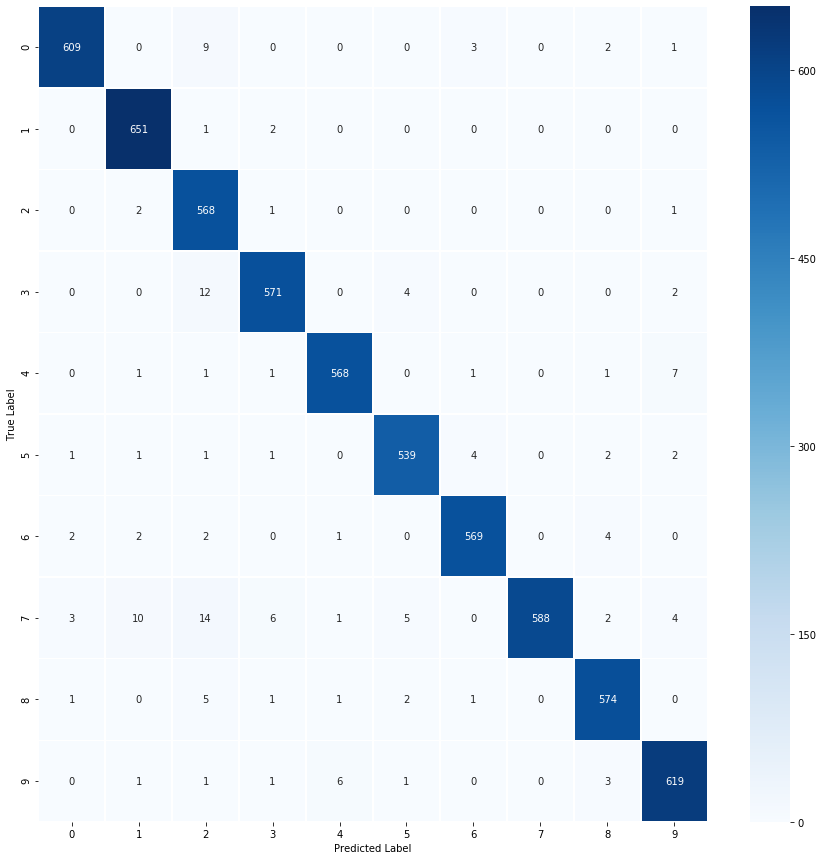

In [195]:
df_cm = pd.DataFrame(cm)
df_cm.index.name = 'True Label'
df_cm.columns.name = 'Predicted Label'
plt.figure(figsize = (15,15))
sn.heatmap(df_cm,cmap="Blues",annot=True,fmt='d',linewidths=.5)